In [12]:
# from IPython.display import display, HTML

# display(HTML(data="""

# <style>
#     div#notebook-container    { width: 90%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

# %reload_ext jupyternotify

# #%notify
#A.C.: I was getting an error and it was useless for me.

In [1]:
import numpy as np
import sys

import qutip as qtp
import matplotlib.pyplot as plt
# from pathlib import Path

from scipy import constants
from scipy import linalg as la
from scipy.optimize import minimize

# parent_path = ".."  #str(Path(__file__).resolve().parents[1])
# sys.path.append(parent_path)

# A.C.: parent_path should be useless if  you install the package

import pysqkit

import time
import datetime
import os

from pysqkit.solvers.solvkit import integrate
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 7)

In [2]:
from math import pi

# h = 6.62607 * 10**(-34)
# h_bar = h/(2*pi)
# e = 1.6071766*10**(-19)
# A.C.: scipy has these constants built-in in the constants module
phi_0 = constants.h/(2*constants.elementary_charge)  

N = 100

$$\hat{H} = \hat{H}^{(0)}_A + \hat{H}^{(0)}_B + \hat{V} + \hat{H}_{drive}$$

$$\hat{H}^{(0)}_A = 4 E_{C,A} \cdot \hat{n}^2_A + \frac{1}{2}E_{L,A}\cdot\hat{\varphi}^2_A - E_{J,A}\cos\left(\hat{\varphi}_A - \phi_{ext,A}\right)$$

$$\hat{H}^{(0)}_B = 4 E_{C,B} \cdot \hat{n}^2_B + \frac{1}{2}E_{L,B}\cdot\hat{\varphi}^2_B - E_{J,B}\cos\left(\hat{\varphi}_B - \phi_{ext,B}\right)$$

$$\hat{V} = J_C \cdot \hat{n}_A \cdot \hat{n}_B$$

$$\hat{H}_{drive} = 2  f\left( t \right)  \cos \left( \omega_d t + \gamma_d\right) \cdot \left( \eta_A \cdot \hat{n}_A + \eta_B \cdot \hat{n}_B \right)   \text{  with  } f\left( t \right) = f_0 \cdot \dfrac{f\left( t \right)}{f_0} $$

# Util

In [3]:
def n_th(maxs, n):  #returns n-th tuple with the i_th term varying between 0 and maxs[i]
    temp = np.zeros(len(maxs))
    for i in range(0, len(temp)):
        temp[i] = (n//np.prod(maxs[i+1:]))%np.prod(maxs[i])
    
    res = [int(k) for k in temp]
    return res

# nb_levels = [1, 1, 5, 1, 1, 1, 2]
# for i in range(np.prod(nb_levels)):
#     print(n_th(nb_levels, i))

In [4]:
def ket(n, **kwargs):
    return  qtp.fock(kwargs['nb_levels'], n_th(kwargs['nb_levels'], n))

def bra(m, **kwargs):
    return qtp.fock(kwargs['nb_levels'], n_th(kwargs['nb_levels'], m)).dag()

def rho_nm(n, m, **kwargs): 
    return ket(n, **kwargs)*bra(m, **kwargs)

## Color maps

In [5]:
def draw_mat(mat, mat_name, vmin = np.NaN, vmax = np.NaN):
    
    if np.isnan(vmin):
        vmin = min(np.min(mat.real), np.min(mat.imag))
    if np.isnan(vmax):
        vmax = np.max([np.max(mat.real), np.max(mat.imag)])
    fig, ax = plt.subplots(1, 3, figsize = (12,5))

    im0 = ax[0].imshow(np.abs(mat), vmin=vmin, vmax=vmax)
    ax[0].set_title("$| "+ mat_name + "_{ij} |$")
    ax[0].set_xlabel('$i$')
    ax[0].set_ylabel('$j$')


    im1 = ax[1].imshow(mat.real, vmin=vmin, vmax=vmax)
    ax[1].set_title("$Re(  "+ mat_name + "_{ij} )$")
    ax[1].set_xlabel('$i$')
    ax[1].set_ylabel('$j$')


    im2 = ax[2].imshow(mat.imag, vmin=vmin, vmax=vmax)
    ax[2].set_title("$Im(  "+ mat_name + "_{ij} )$")
    ax[2].set_xlabel('$i$')
    ax[2].set_ylabel('$j$')

    fig.colorbar(im2, ax=ax.ravel().tolist(), orientation = 'horizontal')

def draw_mat_mult(mat_list, mat_name_list, vmin = np.NaN, vmax = np.NaN):
    fig, ax = plt.subplots(len(mat_list), 3, figsize = (12,4*len(mat_list)))
    
    for i in range(len(mat_list)):
        
        if np.isnan(vmin):
            vmin = min(np.min(mat_list[i].real), np.min(mat_list[i].imag))
        if np.isnan(vmax):
            vmax = np.max([np.max(mat_list[i].real), np.max(mat_list[i].imag)])
            
        
        im0 = ax[i, 0].imshow(np.abs(mat_list[i]), vmin=vmin, vmax=vmax)
        ax[i, 0].set_title("$| "+ mat_name_list[i] + "_{ij} |$")
        ax[i, 0].set_xlabel('$i$')
        ax[i, 0].set_ylabel('$j$')


        im1 = ax[i, 1].imshow(mat_list[i].real, vmin=vmin, vmax=vmax)
        ax[i, 1].set_title("$Re(  "+ mat_name_list[i] + "_{ij} )$")
        ax[i, 1].set_xlabel('$i$')
        ax[i, 1].set_ylabel('$j$')


        ax[i, 2].imshow(mat_list[i].imag, vmin=vmin, vmax=vmax)
        ax[i, 2].set_title("$Im(  "+ mat_name_list[i] + "_{ij} )$")
        ax[i, 2].set_xlabel('$i$')
        ax[i, 2].set_ylabel('$j$')

        fig.colorbar(im0, ax=ax[i, :].ravel().tolist(), orientation = 'vertical')


## Fourier

In [6]:
def flat_top(N):

    """
    See: https://en.wikipedia.org/wiki/Window_function#Flat_top_window
    """

    n = np.arange(N)

    a_0 = 0.21557895
    a_1 = 0.41663158
    a_2 = 0.277263158
    a_3 = 0.083578947
    a_4 = 0.006947368

    w_n = (+a_0
           -a_1*np.cos(2*np.pi*n/N)
           +a_2*np.cos(4*np.pi*n/N)
           -a_3*np.cos(6*np.pi*n/N)
           +a_4*np.cos(8*np.pi*n/N))

    return w_n/np.mean(w_n)



def fourier(phi_t, t, f_min, f_max, n_zero_padding=0, door_func=None, real=True):

    """
    Custom fourier function to perform proper spectral analysis according to my needs.
    Return the fourier transform of the signal, as well as the frequencices array.
    args:
        phi_t: the time fonction, 1D array of length n
        t: evenly sampeled time array, 1D array of length n
        f_min: fraction of the time signal at which to start
        f_max: fraction of the time signal at which to end
        n_zero_padding: the number of time we zero pad the signal
        door_func: the door function to us with the zero padding
        real: do we return only the first half of the FT
    return:
        phi_w: the frequency representation of the signal
        w: the evenly sampled frequency array
    """

    if(door_func is None):
        door_func = lambda x:1

    n_max = int(len(t)*f_max)
    n_min = int(len(t)*f_min)
    n = n_max - n_min
    dt = t[1]-t[0]
    f_t = door_func(n)

    if(n_zero_padding == 0):
        phi_t = phi_t[n_min:n_max]
    else:
        phi_t = np.concatenate([
            phi_t[n_min:n_max]*(n_zero_padding+1)*f_t, np.zeros((n_zero_padding*n))])
    n = n*(n_zero_padding+1)

    dw = 2*np.pi/(dt*n)

    if(real):
        w = np.arange(0, n//2)*dw
        phi_w = np.abs(2 * np.fft.fft(phi_t)[:n//2]/n)
    else:
        w = np.arange(0, n)*dw
        phi_w = np.fft.fft(phi_t)[:n]/n

    return phi_w, w

# Functions

In [7]:
def gate_all_time(state_init, **kwargs): #takes a dictionnary all the following quantities
                
    duo_H = kwargs['duo_H']
    drive_list = kwargs['drive_list']
    pulse_fct_list = kwargs['pulse_fct_list']#list of functions to calculate the pulse arrays
    jump_list = kwargs['jump_list']
    solver = kwargs['solver']
    
    time = np.linspace(kwargs['t_init'], kwargs['t_fin'], kwargs['N'])
    
    pulse_list = []
    for i in range(len(pulse_fct_list)):
        pulse_list.append(
            np.array([pulse_fct_list[i](tt, **kwargs) for tt in time]) 
        )#kwargs also contains the necessary arguments for the pulse functions
        
    res = integrate(time, state_init, duo_H, drive_list, pulse_list, jump_list, solver)
    
    return res

def gate(state_init, **kwargs): #gate is straight forward 
    #and the signature aims to be usable by the tomography module
    return gate_all_time(state_init, **kwargs)[-1]



In [8]:
def set_up_exp(**kwargs): #returns a dic with all the information necessary AND the informations from the kwargs
    
    #copy to avoid changing parameters 
    flxA = pysqkit.qubits.Fluxonium(label = "QBA",
                               charge_energy=kwargs['flxA'].charge_energy,
                               induct_energy=kwargs['flxA'].induct_energy,
                               joseph_energy=kwargs['flxA'].joseph_energy,
                               flux=kwargs['flxA'].flux,
                               basis=None,
                               dim_hilbert=kwargs['flxA'].dim_hilbert)
    
    flxB = pysqkit.qubits.Fluxonium(label = "QBB",
                               charge_energy=kwargs['flxB'].charge_energy,
                               induct_energy=kwargs['flxB'].induct_energy,
                               joseph_energy=kwargs['flxB'].joseph_energy,
                               flux=kwargs['flxB'].flux,
                               basis=None,
                               dim_hilbert=kwargs['flxB'].dim_hilbert)

    
    
    #prep A
    flxA.diagonlize_basis(num_levels=kwargs['nb_levels'][0])
    bare_E_A = flxA.eig_energies()
    omega_01_A = (bare_E_A[1] - bare_E_A[0] )*2*np.pi 
    n_10_A = np.abs(flxA.mat_elements('charge_op')).data[1,0]
    n_01_A = np.abs(flxA.mat_elements('charge_op')).data[0,1]
    
    #pres B
    flxB.diagonlize_basis(num_levels=kwargs['nb_levels'][1])
    bare_E_B = flxB.eig_energies()
    omega_01_B = (bare_E_B[1] - bare_E_B[0])*2*np.pi
    n_10_B = np.abs(flxB.mat_elements('charge_op')).data[1,0]
    n_01_B = np.abs(flxB.mat_elements('charge_op')).data[0,1]
    
    #build duo
    duo = flxA.couple_to(flxB, pysqkit.couplers.capacitive_coupling, strength = J_c)
    H_duo_tot = duo.hamiltonian(as_qobj = True)

    #build drive
    n_A = flxA.charge_op(as_qobj = True)
    n_B = flxB.charge_op(as_qobj = True)
    drive = qtp.tensor(n_A, qtp.qeye(kwargs['nb_levels'][1]))*kwargs['eta_A'] + \
            qtp.tensor(qtp.qeye(kwargs['nb_levels'][0]), n_B)*kwargs['eta_B']
    
    #build pulse_fct
    def pulse_fct(t, **kwargs):
        f_0 = kwargs['lam']/2 * np.abs(kwargs['omega_01_A'] - kwargs['omega_01_B']) / (kwargs['n_10_A'])
        t_rise = kwargs['t_rise']
        sigma = t_rise/2
        
        if t<t_rise:
            f = f_0 * (np.exp(- (t-t_rise)**2 / (2*sigma**2)) - np.exp(-t_rise**2 /(2*sigma**2)))
            
        else:
            f = f_0
            
        pulse = 2 * f * np.cos(kwargs['omega_d']*t)
        return pulse
    
    #def another dictionnary
    param_gate = {}
    for string in kwargs.keys():
        param_gate[string] = kwargs[string]
        
    param_gate['omega_01_A'] = omega_01_A
    param_gate['omega_01_B'] = omega_01_B
    param_gate['n_10_A'] = n_10_A
    param_gate['duo_H'] = duo.hamiltonian(as_qobj = True)
    param_gate['drive_list'] =  [drive]
    param_gate['pulse_fct_list'] = [pulse_fct]
    
    
    return param_gate                                                           
                                                                     
                                                                     

In [9]:
def optim_function(o_d, kwargs): #function to minimize to find the optimal omega_d
    dic1 = {}
    for ke in kwargs.keys():
        dic1[ke] = kwargs[ke]
    dic1['omega_d'] = o_d
    
    dic2 = set_up_exp(**dic1)

    ket_init = ket(0, **dic2)
    output = gate_all_time(ket_init, **dic2)
    min_00_00 = np.min([np.abs(out.full()[0])**2 for out in output.states])
    max_00_11 = np.max([np.abs(out.full()[kwargs['nb_levels'][0] + kwargs['nb_levels'][1]])**2 for out in output.states])
    
    delta = (max_00_11 - min_00_00)
    return 1 - delta

# Parameters

In [10]:
# e_c_A = 1 #1*10**9 *h
# e_l_A = 1.5 #1.5*10**9 *h
# e_j_A = 3.8 #3.8*10**9 *h
# flux_A = 1/2  # 1/2 -> pi in the cosine


# e_c_B = 1 #1*10**9 *h
# e_l_B = .9 #.9*10**9 *h
# e_j_B = 3 #3*10**9 *h
# flux_B = 1/2


# J_c = .3 #300*10**6 *h


# lam = .5
# omega_d = 2*pi * (1.15+0.84)/2



In [11]:
param_exp_from_scratch = {
    'flxA' : pysqkit.qubits.Fluxonium(label = "QBA",
                               charge_energy=e_c_A,
                               induct_energy=e_l_A,
                               joseph_energy=e_j_A,
                               flux=flux_A,
                               basis=None,
                               dim_hilbert=N),
    'flxB' : pysqkit.qubits.Fluxonium(label = "QBB",
                               charge_energy=e_c_B,
                               induct_energy=e_l_B,
                               joseph_energy=e_j_B,
                               flux=flux_B,
                               basis=None,
                               dim_hilbert=N),
   
    'nb_systems' : 2,
    'nb_levels' : [5,5],
    
    'J_c' : J_c,  #could be a matrix
    
    'lam' : lam,
    'omega_d' : omega_d,
    'eta_A' : 1,
    'eta_B' : 1,
    't_rise' : 25,
    
    't_init' : 0,
    't_fin' : 200,
    'N' : 5000,
    
    'jump_list' : [],
    
    'solver' : pysqkit.solvers.solvkit.supported_solvers[0]
}
param_exp_from_scratch['d'] = np.prod(param_exp_from_scratch['nb_levels'])

#we init omega_d at omega_bar
param_exp_from_scratch['omega_d'] = 1/2 *  ((param_exp_from_scratch['flxA'].eig_energies()[1] - param_exp_from_scratch['flxA'].eig_energies()[0]) +
                            param_exp_from_scratch['flxB'].eig_energies()[1] - param_exp_from_scratch['flxB'].eig_energies()[0]) * 2*np.pi
print(param_exp_from_scratch['omega_d']/(2*np.pi))

1.0002602414166508


In [12]:
print("For flxA : omega_01 = ", param_exp_from_scratch['flxA'].eig_energies()[1] - param_exp_from_scratch['flxA'].eig_energies()[0], "GHz")
print("For flxB : omega_01 = ", param_exp_from_scratch['flxB'].eig_energies()[1] - param_exp_from_scratch['flxB'].eig_energies()[0], "GHz")

For flxA : omega_01 =  1.1516938223020352 GHz
For flxB : omega_01 =  0.848826660531266 GHz


## Omega_d

### with minimize (unsuccessfully)

In [ ]:
omega_d, optim_function(omega_d, param_exp_from_scratch)

In [ ]:
deb = time.time()
res = minimize(optim_function, [omega_d], *[param_exp_from_scratch] )
print("It took :", time.time() - deb, ' seconds')

In [ ]:
res.x[0], optim_function(res.x[0], param_exp_from_scratch)

### manual

In [17]:
print("For flxA : omega_01 = ", param_exp_from_scratch['flxA'].eig_energies()[1] - param_exp_from_scratch['flxA'].eig_energies()[0], "GHz")
print("For flxB : omega_01 = ", param_exp_from_scratch['flxB'].eig_energies()[1] - param_exp_from_scratch['flxB'].eig_energies()[0], "GHz")

print("So, omega_bar = ", 1/2 *  ((param_exp_from_scratch['flxA'].eig_energies()[1] - param_exp_from_scratch['flxA'].eig_energies()[0]) +
                                  param_exp_from_scratch['flxB'].eig_energies()[1] - param_exp_from_scratch['flxB'].eig_energies()[0]), "GHz")

For flxA : omega_01 =  1.1516938223020352 GHz
For flxB : omega_01 =  0.848826660531266 GHz
So, omega_bar =  1.0002602414166508 GHz


In [18]:
param_exp_from_scratch['N'] = 5000
param_exp_from_scratch['t_fin'] = 1000

It'll take  2020.5161571502686 seconds (= 33.68 minutes)
Will end around  2021-05-06 17:00:51.803132
It took : 1662.3584072589874  seconds


<IPython.core.display.Javascript object>


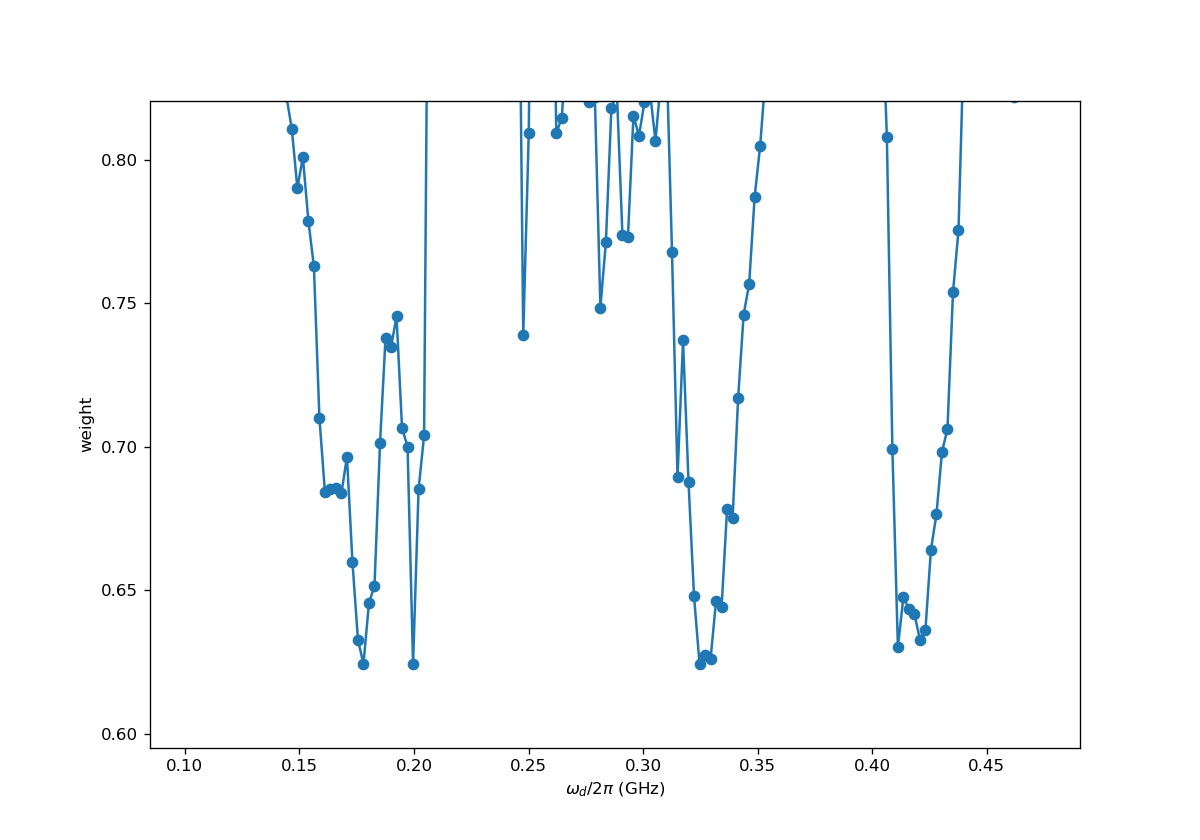

<IPython.core.display.Javascript object>

In [121]:
#weigth on a large spectrum

tab_omega = np.linspace(0, 1.2, 100)*2*np.pi

deb = time.time()
optim_function(omega_d, param_exp_from_scratch)
duration = time.time() - deb
print("It'll take ", duration * len(tab_omega),"seconds (=", np.round((duration * len(tab_omega))/60 , 2), "minutes)")
print("Will end around ", datetime.datetime.now()+ datetime.timedelta(seconds = duration * len(tab_omega) ))

weights = []
for o in tab_omega:
    weights.append(optim_function(o, param_exp_from_scratch))
    
print("It took :", time.time() - deb, ' seconds')



plt.figure()
plt.plot(np.array(tab_omega)/(2*np.pi), weights)
plt.scatter(np.array(tab_omega)/(2*np.pi), weights)

plt.xlabel('$\omega_d / 2\pi$ (GHz)')
plt.ylabel('weight')

%notify

In [122]:
omega_d_opt = tab_omega[np.argmin(weights)]
param_exp_from_scratch['omega_d'] = omega_d_opt

print(param_exp_from_scratch['omega_d']/(2*np.pi))

0.19959919839679358


# Experiments

In [39]:
param_exp_from_scratch['N'] = 10000
param_exp_from_scratch['t_fin'] = 2000


param_exp = set_up_exp(**param_exp_from_scratch)#fill the dict

In [40]:
ket_init = ket(0, **param_exp)
# dens_mat_init = ket_init*ket_init.dag()

# dens_mat_init
# ket_init

In [41]:
deb = time.time()
output = gate_all_time(ket_init, **param_exp)

print("It took ", time.time() - deb, "seconds")
%notify

It took  7.978017091751099 seconds


<IPython.core.display.Javascript object>

## Matrix elements

<IPython.core.display.Javascript object>


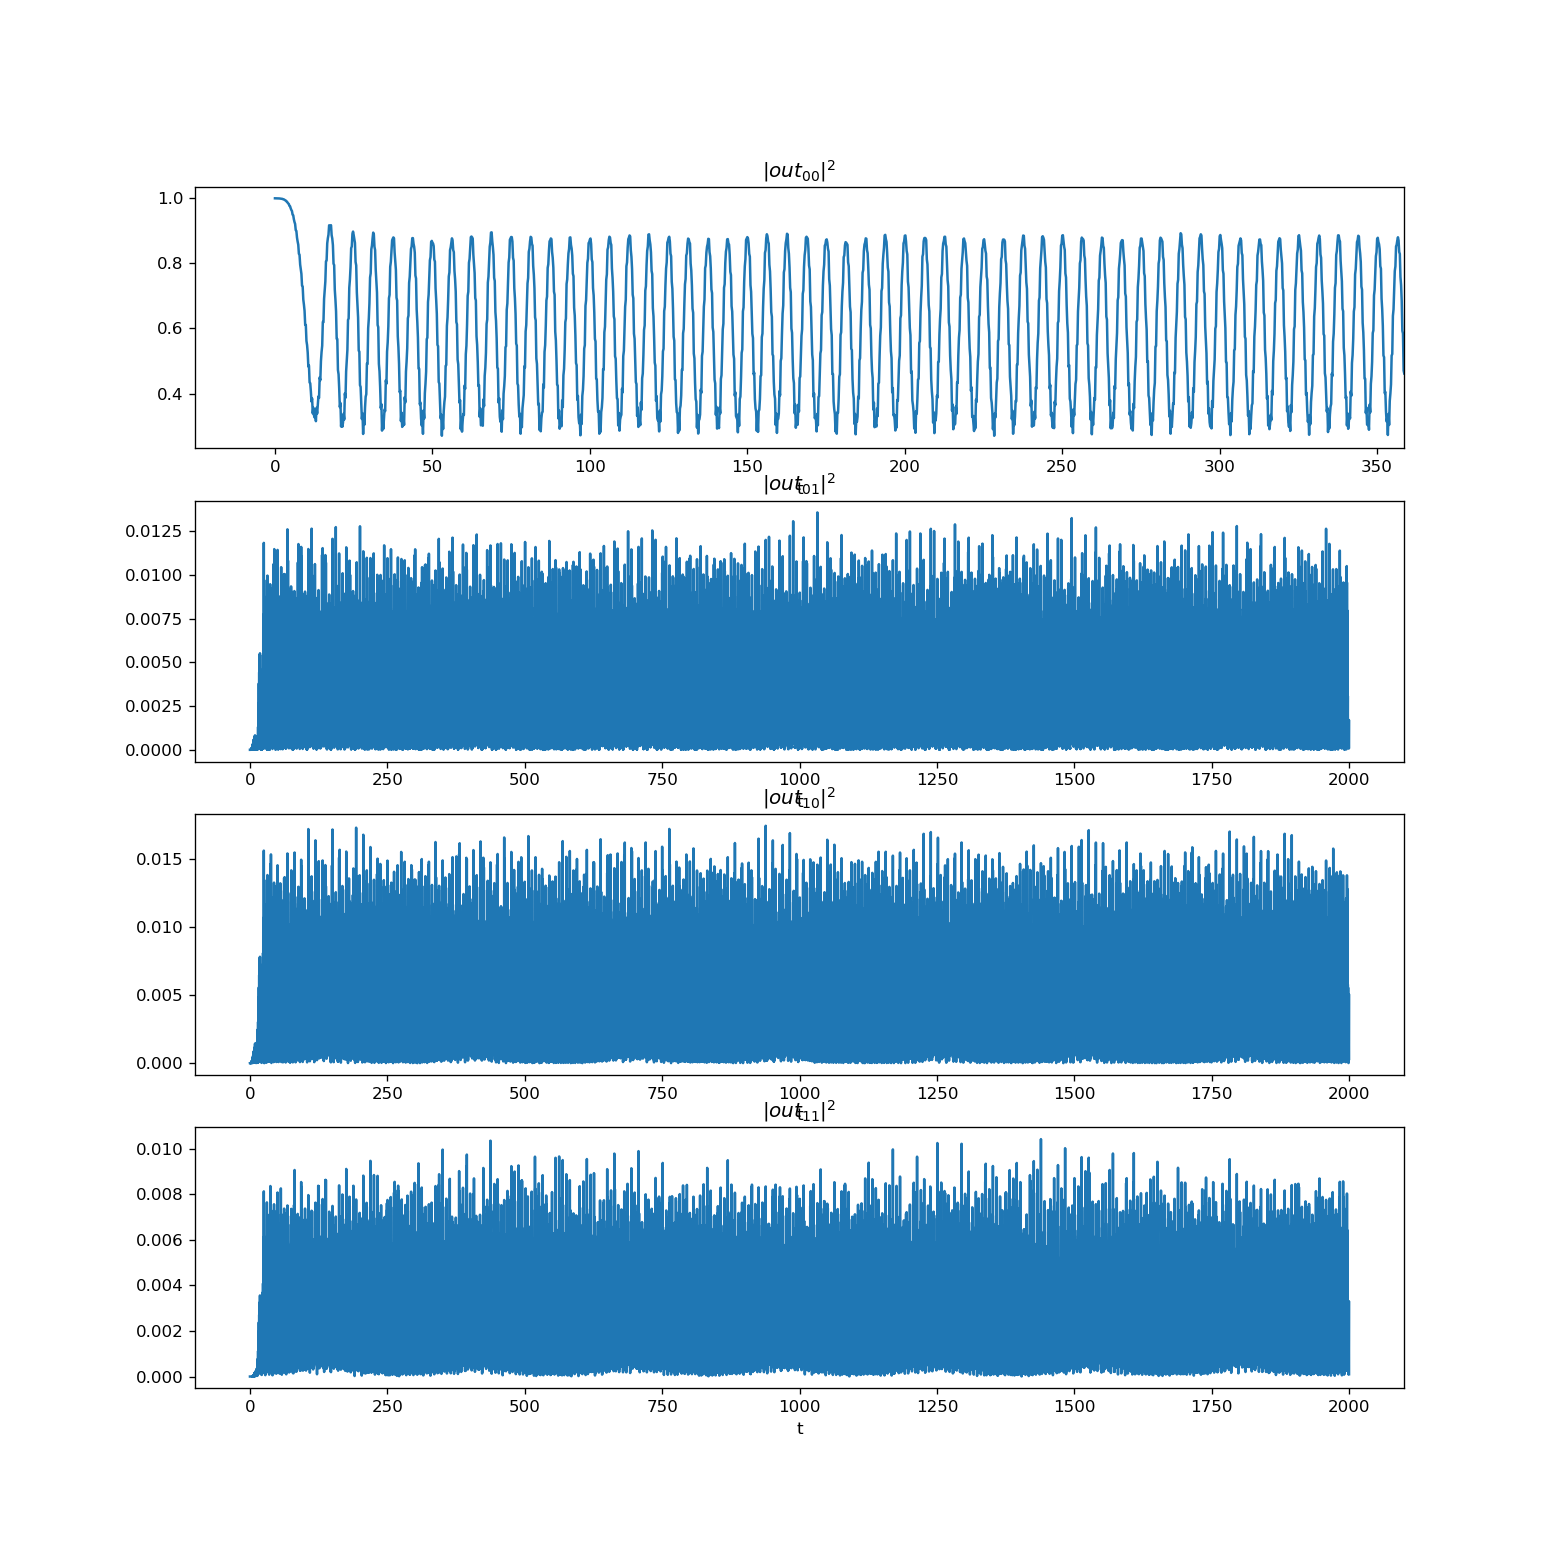

In [42]:
#Coefs plots
interesting_coefs = [0, 1, param_exp['nb_levels'][1], param_exp['nb_levels'][1] + param_exp['nb_levels'][0]] #for 00, 01, 10, 11
coef_names = ["00", "01", "10", "11"]

x, y = 4,1 #output.states[0].shape
fig, ax = plt.subplots(x, y, figsize = [13, 13])

##for rhos
# for a in range(x):
#     for b in range(y):

#         im = ax[a,b].plot(np.linspace(param_exp['t_init'], param_exp['t_fin'], param_exp['N']), 
#                           [(psi.full()[a, b]*np.conj(psi.full()[a, b])).real for psi in output.states])
#         ax[a,b].set_title("$| out _{"+ str((a,b))+"} |$")
#         ax[a,b].set_xlabel('t')

#for kets

for i in range(len(interesting_coefs)):
    a = interesting_coefs[i]
    im = ax[i].plot(np.linspace(param_exp['t_init'], param_exp['t_fin'], param_exp['N']), 
                      [(psi.full()[a]*np.conj(psi.full()[a])).real for psi in output.states])#[psi.full()[a].real for psi in output.states])
    ax[i].set_title("$| out _{"+ coef_names[i] +"} |^2$")
    ax[i].set_xlabel('t')


In [43]:
print(param_exp['omega_d']/(2*np.pi))

%notify

1.0002602414166508


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


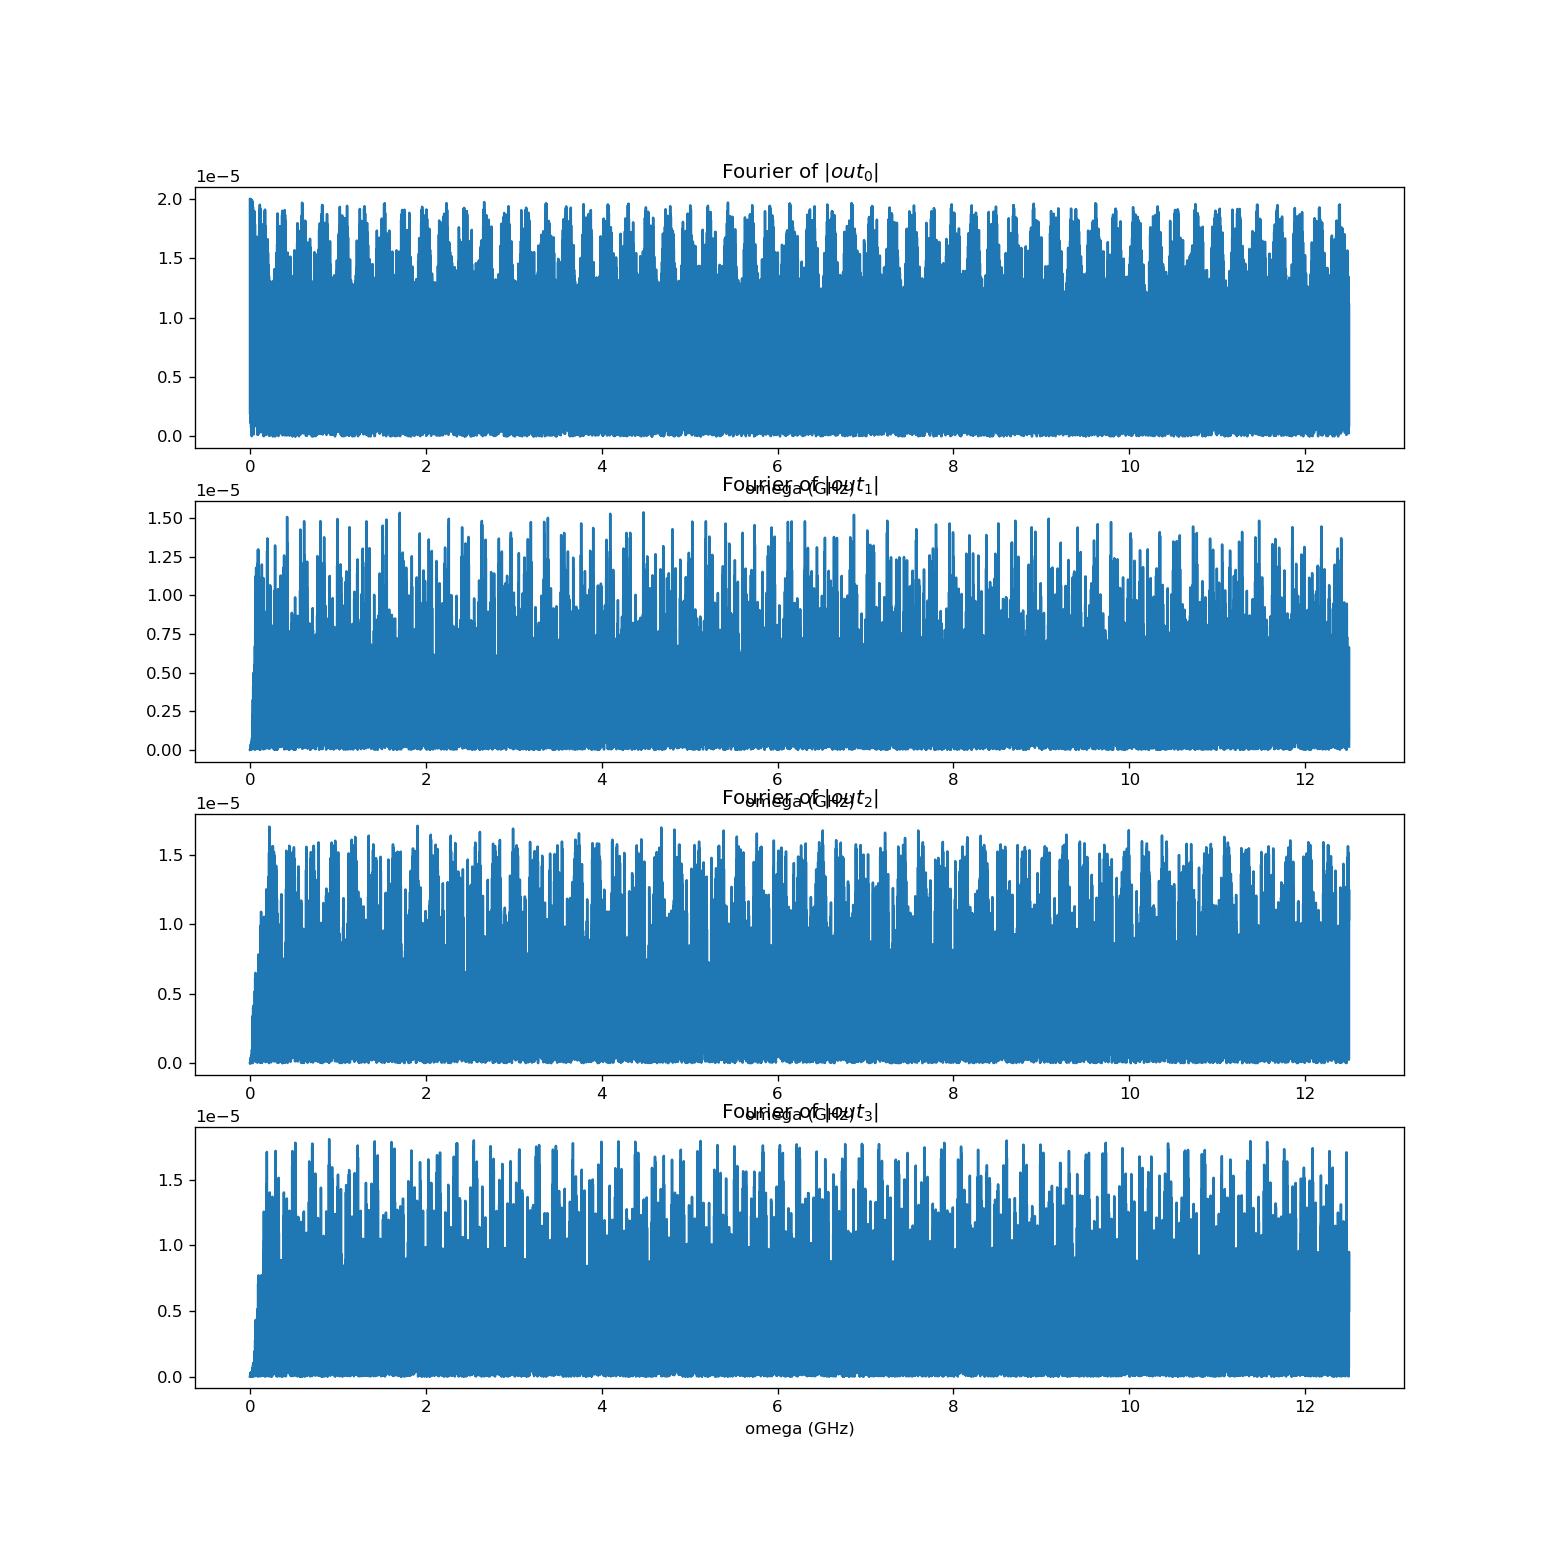

In [49]:
#TFs of coefs evolutions
        
# x, y = output.states[0].shape
# fig, ax = plt.subplots(x, y, figsize = [13, 13])

# for a in range(x):
#     for b in range(y):
#         phi, w = fourier([np.abs(rho[a,b]) for rho in output.states], np.linspace(param_exp['t_init'], param_exp['t_fin'], param_exp['N']), 0, 1)
        
#         ind_max = 0
#         while w[ind_max]<4:
#             ind_max+=1
        
#         im = ax[a,b].plot(w[:ind_max], phi[:ind_max])
#         ax[a,b].set_title("Fourier of $| out _{"+ str((a,b))+"} |$")
#         ax[a,b].set_xlabel('omega (GHz)')
#         ax[a,b].set_yscale('log')
#         ax[a,b].set_xscale('log')


x, y = output.states[0].shape
fig, ax = plt.subplots(x, y, figsize = [13, 13])

for a in range(x):
    phi, w = fourier([(rho.full()[a]).real for rho in output.states], np.linspace(param_exp['t_init'], param_exp['t_fin'], param_exp['N']), 0, 1)

    ind_max = 0
    while w[ind_max]<6:
        ind_max+=1

    im = ax[a].plot(w[:]/(2*np.pi), phi[:])
    ax[a].set_title("Fourier of $| out _{"+ str((a))+"} |$")
    ax[a].set_xlabel('omega (GHz)')
#     ax[a].set_yscale('log')
#     ax[a].set_xscale('log')



<IPython.core.display.Javascript object>


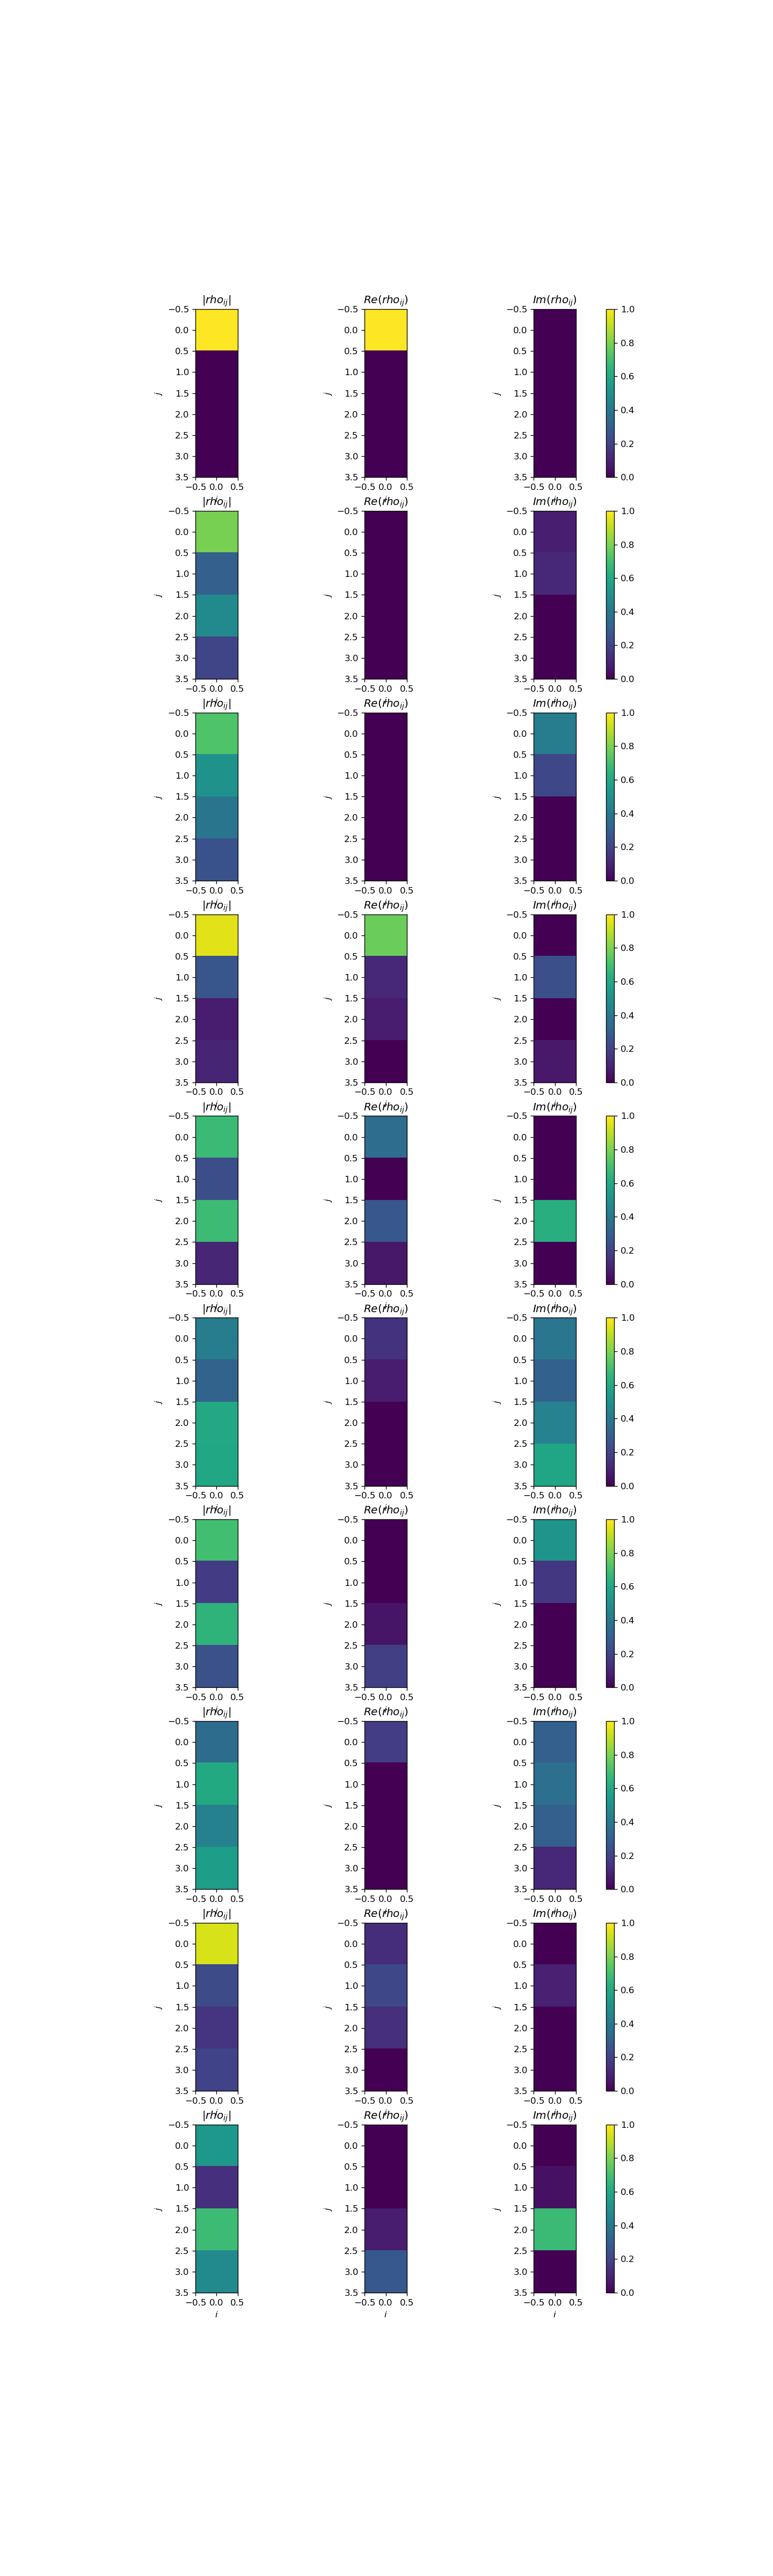

In [50]:
#Intermadiate matrices plot
it = 10
mat_list = []
mat_name_list = []

for i in range(it):
    mat_list.append(output.states[i*len(output.states)//it].full())
    mat_name_list.append(" rho ")
    
draw_mat_mult(mat_list, mat_name_list)